# Dog breed classifiaction with Pytorch

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
!pip install smdebug
!pip install torch --no-cache-dir

In [1]:
import sagemaker
import boto3
import torch
import matplotlib.pyplot as plt
from sagemaker.pytorch import PyTorch
import gzip 
import random
import os
from sagemaker.session import Session
from sagemaker import get_execution_role
from glob import glob

## Dataset
The dataset for this project is dogImages including 133 different dog breeds. 

In [3]:
dog_names = [item[22:-1] for item in sorted(glob("./dogImages/train/*/"))]


In [4]:
print(dog_names)

['Affenpinscher', 'Afghan_hound', 'Airedale_terrier', 'Akita', 'Alaskan_malamute', 'American_eskimo_dog', 'American_foxhound', 'American_staffordshire_terrier', 'American_water_spaniel', 'Anatolian_shepherd_dog', 'Australian_cattle_dog', 'Australian_shepherd', 'Australian_terrier', 'Basenji', 'Basset_hound', 'Beagle', 'Bearded_collie', 'Beauceron', 'Bedlington_terrier', 'Belgian_malinois', 'Belgian_sheepdog', 'Belgian_tervuren', 'Bernese_mountain_dog', 'Bichon_frise', 'Black_and_tan_coonhound', 'Black_russian_terrier', 'Bloodhound', 'Bluetick_coonhound', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_terrier', 'Bouvier_des_flandres', 'Boxer', 'Boykin_spaniel', 'Briard', 'Brittany', 'Brussels_griffon', 'Bull_terrier', 'Bulldog', 'Bullmastiff', 'Cairn_terrier', 'Canaan_dog', 'Cane_corso', 'Cardigan_welsh_corgi', 'Cavalier_king_charles_spaniel', 'Chesapeake_bay_retriever', 'Chihuahua', 'Chinese_crested', 'Chinese_shar-pei', 'Chow_chow', 'Clumber_spaniel', 'Cocker_spaniel', 'Collie',

In [2]:
sessio = sagemaker.Session()
bucket = sessio.default_bucket()
print("Default Bucket: {}".format(bucket))
region =sessio.boto_region_name
print("AWS region: {}".format(region))
role = get_execution_role()
data_directory= 'myproject3'
print("Role : {}".format(role), data_directory)

Default Bucket: sagemaker-us-east-1-896725556613
AWS region: us-east-1
Role : arn:aws:iam::896725556613:role/service-role/AmazonSageMaker-ExecutionRole-20211214T154543 myproject3


In [ ]:

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [ ]:
# Fetch and upload the data to AWS S3

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/data_directory/dogImages

In [6]:
inputs= 's3://'+bucket+'/'+data_directory+'/dogImages/'
#inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-896725556613/myproject3/dogImages/


## Hyperparameter Tuning
This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.


In [7]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

In [8]:
# Define our success metric and a regular expression for finding that metric in the training job logs.
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [9]:
#Declare your HP ranges, metrics etc. "epochs": IntegerParameter(2, 4)
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

In [16]:

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type
)

In [17]:
os.environ['SM_CHANNEL_TRAINING'] = 's3://'+bucket+'/'+data_directory+'/dogImages/'
os.environ['SM_MODEL_DIR'] = 's3://'+bucket+'/'+data_directory+'/dogImages/model/'
os.environ['SM_OUTPUT_DATA_DIR'] = 's3://'+bucket+'/'+data_directory+'/dogImages/output/'

In [18]:
# Fit HP Tuner
tuner.fit({'training': inputs})


..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [19]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2021-12-23 12:36:35 Starting - Preparing the instances for training
2021-12-23 12:36:35 Downloading - Downloading input data
2021-12-23 12:36:35 Training - Training image download completed. Training in progress.
2021-12-23 12:36:35 Uploading - Uploading generated training model
2021-12-23 12:36:35 Completed - Training job completed


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"64"',
 'learning_rate': '0.011518064024672314',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2021-12-23-11-52-22-871"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-896725556613/pytorch_dog_hpo-2021-12-23-11-52-22-871/source/sourcedir.tar.gz"'}

In [25]:
best_hpo={'batch_size': best_estimator.hyperparameters()['batch_size'].replace('"', ""),
          'learning_rate': best_estimator.hyperparameters()['learning_rate']}
print(f"The best hpo:\n {best_hpo}")

The best hpo:
 {'batch_size': '64', 'learning_rate': '0.011518064024672314'}


# If the kernel is restarted follow the next 4 

In [142]:
# if the kernel is restarted :
BestTrainingJobName = 'pytorch-training-2021-12-22-11-11-44-732'
my_estimator = sagemaker.estimator.Estimator.attach(BestTrainingJobName)



2021-12-22 11:32:56 Starting - Preparing the instances for training
2021-12-22 11:32:56 Downloading - Downloading input data
2021-12-22 11:32:56 Training - Training image download completed. Training in progress.
2021-12-22 11:32:56 Uploading - Uploading generated training model
2021-12-22 11:32:56 Completed - Training job completed


In [ ]:
my_estimator.hyperparameters()

In [ ]:
best_estimator=my_estimator

In [ ]:
#'epoch': int(best_estimator.hyperparameters()['epoch'].replace('"',""))
best_hpo={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
          'learning_rate': best_estimator.hyperparameters()['learning_rate'].replace('"',"")}
print(f"The best hpo:\n {best_hpo}")

## Model Profiling and Debugging
Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [180]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

# Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [181]:
# kernel died, so i manually add the hpo
best_hpo= {'batch_size': "256", 'learning_rate': "0.004726993511256629"}

In [182]:
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config=DebuggerHookConfig(
    collection_configs=collection_configs
)

estimator = PyTorch(
    entry_point='train_model.py',
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge', 
    hyperparameters=best_hpo,
    framework_version='1.4.0',
    py_version='py3',
    #env={"MMS_DEFAULT_RESPONSE_TIMEOUT": "6000"},
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

In [183]:
print(os.environ['SM_CHANNEL_TRAINING'], inputs)

s3://sagemaker-us-east-1-896725556613/myproject3/dogImages/ s3://sagemaker-us-east-1-896725556613/myproject3/dogImages/


In [184]:
estimator.fit({"training": inputs}, wait=True)


2021-12-23 17:56:26 Starting - Starting the training job...
2021-12-23 17:56:50 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2021-12-23 17:57:50 Starting - Preparing the instances for training.........
2021-12-23 17:59:11 Downloading - Downloading input data.........
2021-12-23 18:00:51 Training - Downloading the training image..
2021-12-23 18:01:11 Training - Training image download completed. Training in progress.[2021-12-23 18:01:24.112 algo-1:44 INFO json_config.py:90] Creating hook from json_config at /opt/ml/input/config/debughookconfig.json.
[2021-12-23 18:01:24.112 algo-1:44 INFO hook.py:192] tensorboard_dir has not been set for the hook. SMDebug will not be exporting tensorboard summaries.
[2021-12-23 18:01:24.112 algo-1:44 INFO hook.py:237] Saving to /opt/ml/output/tensors
[2021-12-23 18:01:24.112 algo-1:44 INFO state_store.py:67] The

## Plot a debugging output


In [185]:
# Plot a debugging output.

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

Training jobname: pytorch-training-2021-12-23-17-56-25-714
Region: us-east-1
[2021-12-23 18:25:02.258 ip-172-16-31-184:1924 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-896725556613/pytorch-training-2021-12-23-17-56-25-714/debug-output
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.2.relu_input_2', 'layer2.3.relu_input_0', 'layer2.3.relu_input_1', 'layer2.3.relu_input_2', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'la

In [186]:
tensor_name = "CrossEntropyLoss_output_0"


In [187]:
from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    print(tensor)
    steps = tensor.steps(mode=mode)
    print(steps)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals



In [188]:
get_data(trial, tensor_name, mode=ModeKeys.TRAIN)

[0, 10, 20]


([0, 10, 20],
 [array(4.916105, dtype=float32),
  array(4.200391, dtype=float32),
  array(2.9799988, dtype=float32)])

In [189]:

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

[0, 10, 20]
loaded TRAIN data
[0, 1, 2, 3, 4, 5, 6, 7]
loaded EVAL data
completed TRAIN plot
completed EVAL plot


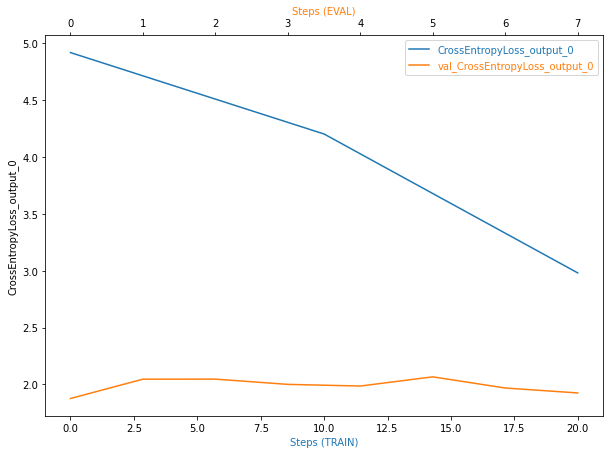

In [191]:
from smdebug.core.modes import ModeKeys
    
# Plot the curve
plot_tensor(trial, 'CrossEntropyLoss_output_0')

Q: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
If not, suppose there was an error. What would that error look like and how would you have fixed it?

A: The above plot does not show any anomaly. By using model with more depth (layers), adding more hyperparameters, or tuning the hyperparameters we can achive to better result. 

## Model Deploying

In [192]:

rule_output_path = estimator.output_path + estimator.latest_training_job.name + "/rule-output"
print(f"Profiler report path: {rule_output_path}")


Profiler report path: s3://sagemaker-us-east-1-896725556613/pytorch-training-2021-12-23-17-56-25-714/rule-output


In [193]:
! aws s3 ls {rule_output_path} --recursive


2021-12-23 18:21:23     358906 pytorch-training-2021-12-23-17-56-25-714/rule-output/ProfilerReport/profiler-output/profiler-report.html
2021-12-23 18:21:22     205244 pytorch-training-2021-12-23-17-56-25-714/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2021-12-23 18:21:18        192 pytorch-training-2021-12-23-17-56-25-714/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2021-12-23 18:21:18     102713 pytorch-training-2021-12-23-17-56-25-714/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-23 18:21:18        126 pytorch-training-2021-12-23-17-56-25-714/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2021-12-23 18:21:18        130 pytorch-training-2021-12-23-17-56-25-714/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2021-12-23 18:21:18       9984 pytorch-training-2021-12-23-17-56-25-714/rule-output/ProfilerReport/profiler-output/profiler-re

In [194]:
! aws s3 cp {rule_output_path} ./ --recursive


download: s3://sagemaker-us-east-1-896725556613/pytorch-training-2021-12-23-17-56-25-714/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-896725556613/pytorch-training-2021-12-23-17-56-25-714/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-896725556613/pytorch-training-2021-12-23-17-56-25-714/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-896725556613/pytorch-training-2021-12-23-17-56-25-714/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-896725556613/pytorch-traini

In [195]:
from IPython.display import FileLink, FileLinks

# Get the profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [196]:
report_file_name = profiler_report_name + "/profiler-output/profiler-report.html"
display("Profiler report link", FileLink(report_file_name))

'Profiler report link'

/home/ec2-user/SageMaker/ProfilerReport/profiler-output/profiler-report.html

In [197]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [198]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

### Getting the estimator data to deploy the model 

In [199]:
# manually inserting the model location because of kernel killed 
model_data_loc = estimator.model_data
#model_data_loc = 's3://sagemaker-us-east-1-896725556613/pytorch-training-2021-12-23-17-56-25-714/output/model.tar.gz'
print(model_data_loc)

s3://sagemaker-us-east-1-896725556613/pytorch-training-2021-12-23-17-56-25-714/output/model.tar.gz


In [261]:
role = sagemaker.get_execution_role()

pytorch_model = PyTorchModel(model_data=model_data_loc, 
                             role=role,
                             entry_point='./code/inference.py',
                             py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [216]:
predictor2 = pytorch_model.deploy(instance_type='ml.m5.large', initial_instance_count=1, )

-----!

### Now that we have deployed the model, we have an endpoint which predicts the dog breed of a given image

In [276]:
import io
from PIL import Image
import torch
import numpy as np

### In order to check our endpoint, we get an image url and send the image as the payload to the endpoint. 

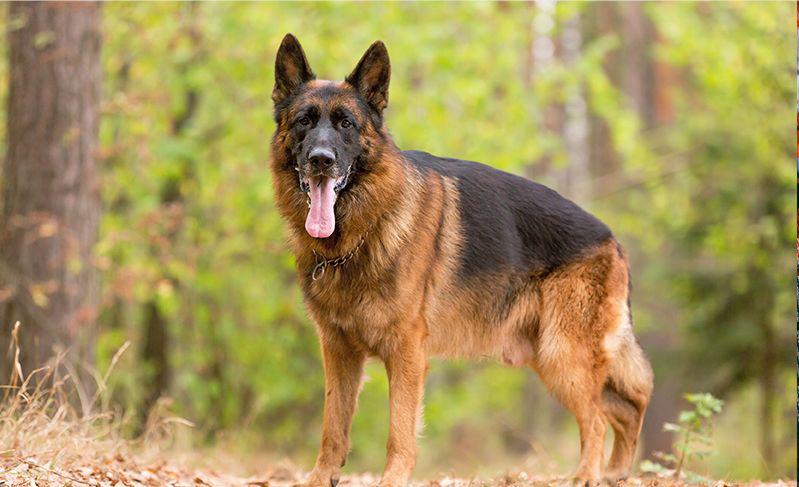

In [277]:
test_image_url = 'https://cdn-cafdl.nitrocdn.com/fQHdfFSxWCuDmbpNBOTabVcchzVvBqxc/assets/static/optimized/rev-f67074a/pub/media/German-shepherd.jpg'
payload = requests.get(test_image_url).content
Image.open(io.BytesIO(payload))

In [278]:
response =predictor2.predict(payload, initial_args={"ContentType": "image/jpeg"})

### Now we can check the response of the endpoint.
### The response is an array of 133 items, each represent a dog breed. 

In [284]:
print(response)

[[-0.28290578722953796, -2.1809935569763184, -3.5977094173431396, 0.7900261878967285, -2.635187864303589, -3.8052899837493896, -1.8231627941131592, -1.3138291835784912, -4.30776309967041, 1.0995137691497803, -0.34528350830078125, -1.6557223796844482, 0.15557873249053955, -2.4100208282470703, -3.342172145843506, -2.091243267059326, -1.9869979619979858, -1.3032987117767334, -4.5270094871521, 3.3280107975006104, -1.7577519416809082, 1.1972137689590454, -3.645075559616089, -4.460986137390137, -3.357405185699463, -3.8390374183654785, -1.270371675491333, -3.94674015045166, -4.3983001708984375, -2.461699962615967, -1.641144037246704, -1.4617193937301636, -6.095257759094238, -2.345580816268921, -1.913287878036499, -1.28746497631073, -1.8985675573349, -1.7600867748260498, -2.2526376247406006, -1.6344785690307617, -1.165244460105896, -5.404037952423096, 0.63990718126297, -1.2903038263320923, -2.6282155513763428, -1.899991750717163, 0.9759187698364258, -2.056868314743042, -3.1492137908935547, -1.

### We get the highest prediction from 133 items and get the corresponding dog name. 

In [279]:
print(np.argmax(response, 1))
print('predicted dog breed:',dog_names[np.argmax(response, 1)[0]])

[19]
predicted dog breed: Belgian_malinois


### Not exactly the correct prediction, but very similar breeds! The model seems to predict well, but it may lacks in correctly predicting very similar breeds.

In [283]:
#deleting the endpoint
predictor2.delete_endpoint()